## MSAE training and feature analysis

Main goal: look at different levels of features in a 3-level MSAE

Steps:

1. Train MSAE on spikes dataset

2. Create (topk) sae feature df

3. Create stim (meta)data df

4. Interp / autointerp
    
    a. Create infra for finding stim at times of particular feature(s)
    
    b. Create infra for finding topk SAE features that fire at times of particular stim

In [1]:
"""Set notebook settings."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

In [2]:
"""Import packages."""

import math
from collections import defaultdict
from dataclasses import dataclass
from functools import partial
from pathlib import Path
from typing import Callable, List, Optional, Tuple

# import jax
import numpy as np
import pandas as pd
import seaborn as sns
import torch as t
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from rich import print as rprint
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from torch import bfloat16, nn, Tensor
from torch.nn import functional as F
from torcheval.metrics.functional import r2_score as tm_r2_score
from tqdm.notebook import tqdm

from mini import train as mt
from mini.util import vec_r2

In [51]:
# Set max rows and cols for df display

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", 25)

In [3]:
"""Spec some dataset info."""

session_id = 732592105
out_dir = Path(r"/nfs/nhome/live/jbhagat/mini/data/allen_data/sessions_proc")
print(f"{out_dir.exists()=}")

# gonna want a gpu if training! not necessary if loading saved features from a trained model
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(f"{device=}")

out_dir.exists()=True
device=device(type='cuda')


In [ ]:
"""Load spikes and set sae config."""

spk_cts_file = out_dir / f"{session_id}" / "spike_counts.csv"
counts_df = pd.read_csv(Path(spk_cts_file), index_col=0)
spk_cts = t.from_numpy(counts_df.to_numpy()).bfloat16().to(device)
spk_cts /= spk_cts.max()  # max normalize spike counts

dsae_topk_map = {256: 8, 512: 16, 1024: 24}
dsae_topk_map = dict(sorted(dsae_topk_map.items()))  # ensure sorted from smallest to largest
dsae_loss_x_map = {256: 1, 512: 1.25, 1024: 1.5}
dsae_loss_x_map = dict(sorted(dsae_loss_x_map.items()))
# dsae_topk_map = {1024: 12, 2048: 24, 4096: 48}
dsae = max(dsae_topk_map.keys())
n_inst = 2

display(counts_df)

## Train MSAE

In [ ]:

sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

SAE batch training step: 100%|██████████| 3560/3560 [00:44<00:00, 80.84it/s, loss=0.00132,  l0_mean=24.0, l0_std=7.4684157371521, frac_dead=0.82666015625]   


## Validate SAEs

In [5]:
"""Check for nans in weights."""

sae.W_dec.isnan().sum(), sae.W_enc.isnan().sum()

(tensor(0, device='cuda:0'), tensor(0, device='cuda:0'))

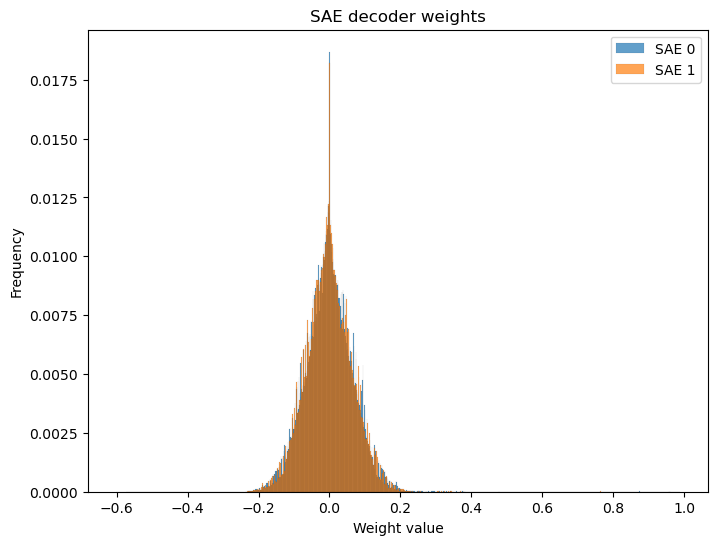

In [ ]:
"""Visualize weights."""

fig, ax = plt.subplots(figsize=(8, 6))
for inst in range(n_inst):
    W_dec_flat = asnumpy(sae.W_dec[inst].float()).ravel()
    sns.histplot(W_dec_flat, bins=1000, stat="probability", alpha=0.7, label=f"SAE {inst}")
    
ax.set_title("SAE decoder weights")
ax.set_xlabel("Weight value")
ax.set_ylabel("Frequency")
ax.legend()

SAE batch evaluation step: 100%|██████████| 178/178 [00:00<00:00, 532.10it/s]


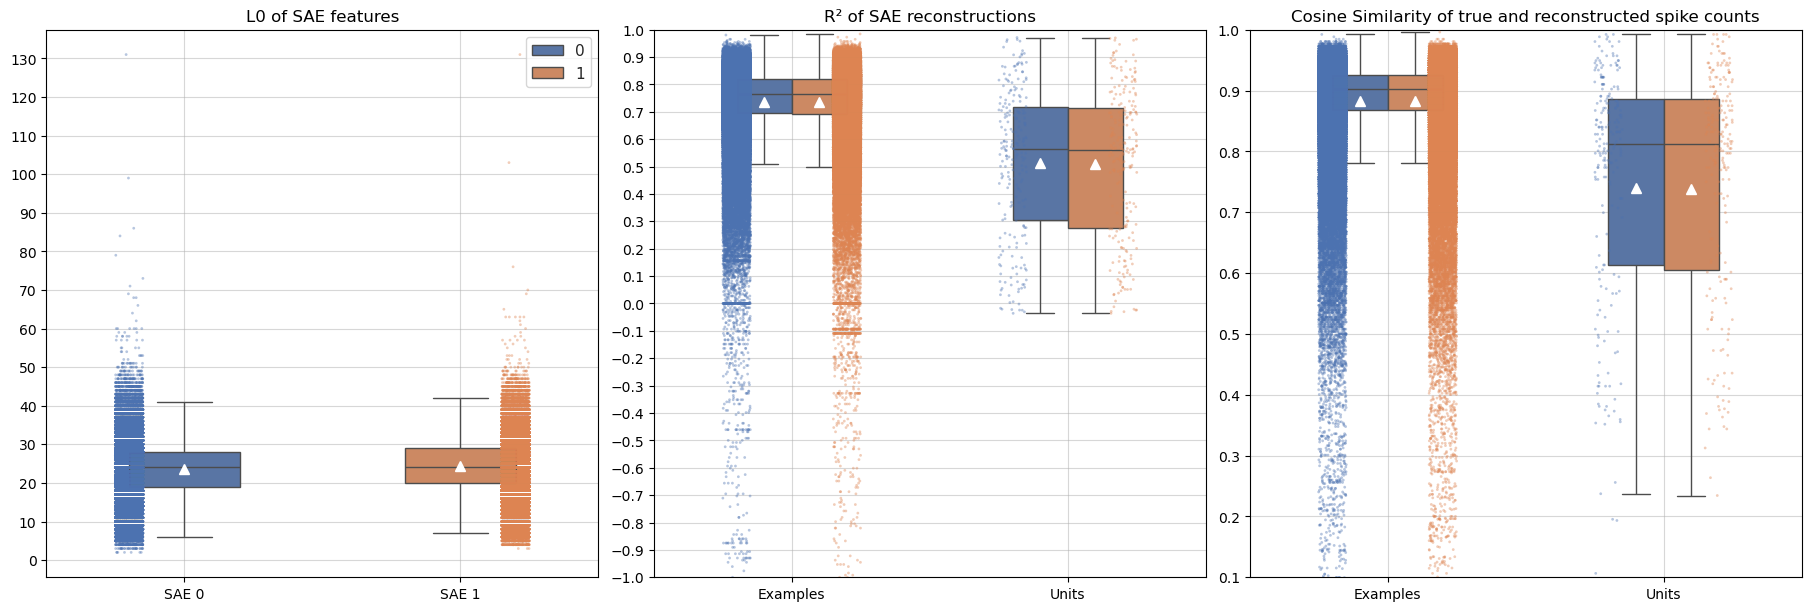

In [15]:
"""Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

In [18]:
"""Calculate variance explained of summed spike counts."""

# Var explained for summed spike counts.
n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")

SAE instance 0 R² (summed spike count over all units per example) = 0.981
SAE instance 1 R² (summed spike count over all units per example) = 0.983


### Remove bad units and retrain.

In [20]:

# Set threshold for removing units
r2_thresh = 0.1
inst = 0
r2_per_unit = r2_per_unit[:, inst]
keep_mask = r2_per_unit > r2_thresh
print(f"frac units above {r2_thresh=}: {keep_mask.sum() / keep_mask.shape[0]:.2f}")
print(f"Number to keep: {keep_mask.sum()} / {keep_mask.shape[0]}")

# Remove units and retrain
spk_cts = spk_cts[:, keep_mask]

sae_cfg = mt.SaeConfig(
    n_input_ae=spk_cts.shape[1],
    dsae_topk_map=dsae_topk_map,
    dsae_loss_x_map=dsae_loss_x_map,
    seq_len=1,
    n_instances=n_inst,
)
sae = mt.Sae(sae_cfg).to(device)
loss_fn = mt.msle
tau = 1.0
lr = 5e-3

n_epochs = 20
batch_sz = 1024
n_steps = spk_cts.shape[0] // batch_sz * n_epochs
log_freq = n_steps // n_epochs // 2
dead_neuron_window = n_steps // n_epochs // 3

data_log = mt.optimize(  # train model
    spk_cts=spk_cts,
    sae=sae,
    loss_fn=loss_fn,
    optimizer=t.optim.Adam(sae.parameters(), lr=lr),
    use_lr_sched=True,
    dead_neuron_window=dead_neuron_window,
    n_steps=n_steps,
    log_freq=log_freq,
    batch_sz=batch_sz,
    log_wandb=False,
    plot_l0=False,
    tau=tau
)

frac units above r2_thresh=0.1: 0.88
Number to keep: 200 / 226


SAE batch training step: 100%|██████████| 3560/3560 [00:37<00:00, 96.09it/s, loss=0.00138,  l0_mean=24.0, l0_std=6.709405422210693, frac_dead=0.8212890625]  


SAE batch evaluation step: 100%|██████████| 178/178 [00:00<00:00, 608.70it/s]


SAE instance 0 R² (summed spike count over all units per example) = 0.983
SAE instance 1 R² (summed spike count over all units per example) = 0.980


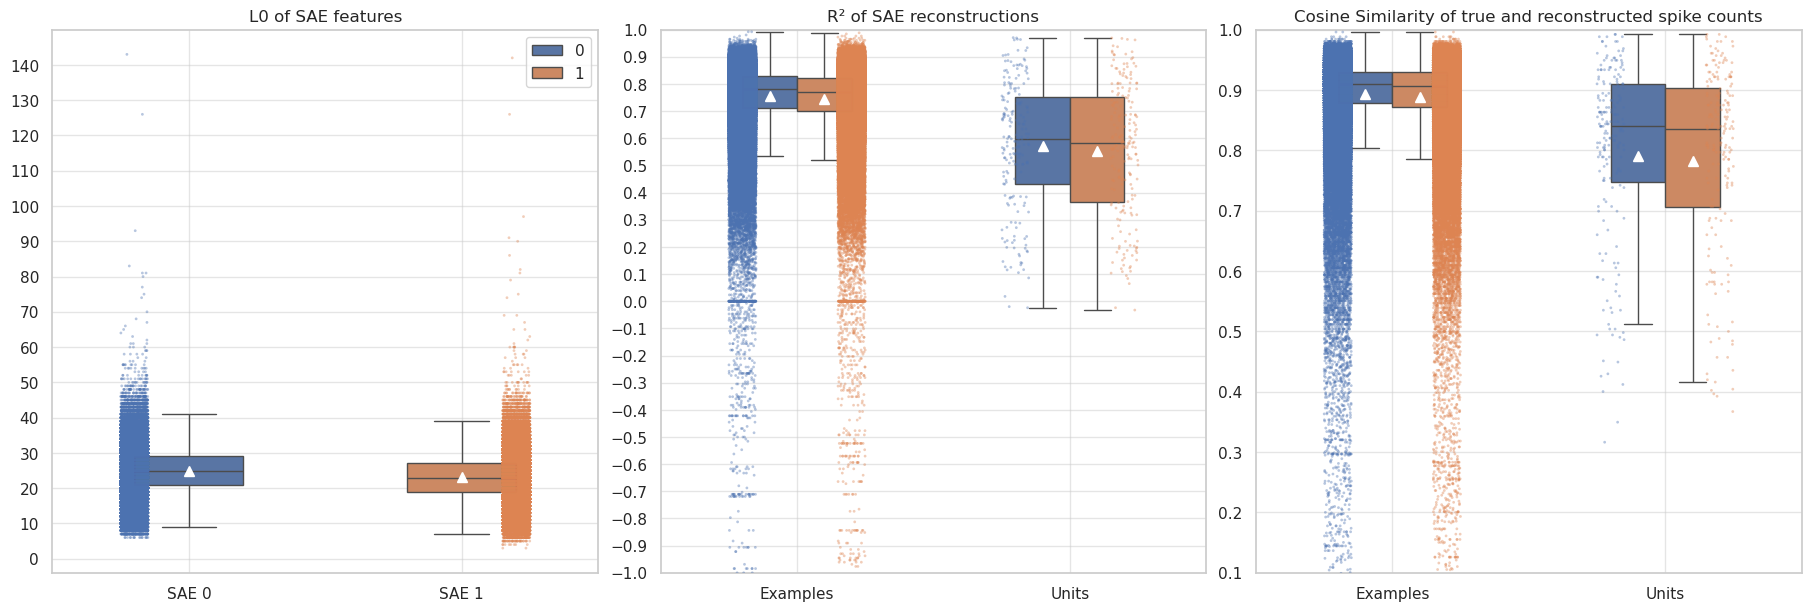

In [21]:
"""Re-Visualize metrics over all examples and units."""

topk_acts_4d, recon_spk_cts, r2_per_unit, _, cossim_per_unit, _ = mt.eval_model(spk_cts, sae, batch_sz=batch_sz)

n_recon_examples = recon_spk_cts.shape[0]
recon_summed_spk_cts = reduce(recon_spk_cts, "example inst unit -> example inst", "sum")
actual_summed_spk_cts = reduce(spk_cts, "example unit -> example", "sum")
actual_summed_spk_cts = actual_summed_spk_cts[0:n_recon_examples]  # trim to match
for inst in range(n_inst):
    r2 = r2_score(
        asnumpy(actual_summed_spk_cts.float()), asnumpy(recon_summed_spk_cts[:, inst].float())
    )
    print(f"SAE instance {inst} R² (summed spike count over all units per example) = {r2:.3f}")


In [ ]:
"""Save spike counts."""

save_spk_cts = True

if save_spk_cts:
    # Save the spike counts to a CSV file
    save_path = out_dir / f"{session_id}" / "spike_counts.csv"
    spk_cts_df = pd.DataFrame(asnumpy(spk_cts))
    spk_cts_df.to_csv(save_path, index=False)
    print(f"Spike counts saved to {save_path}")

## Get environment / behavior (meta)data

In [67]:
"""Set vars for saving / loading environment / behavior (meta)data!"""

load_metadata = False
save_metadata = False
metadatafile = out_dir / f"{session_id}" / "metadata.csv"
bin_s = 0.05  # 50 ms sampling


In [5]:
"""Load metadata."""

if load_metadata:
    metadata = pd.read_csv(metadatafile)

/tmp/ipykernel_1776695/3068544993.py:4: DtypeWarning: Columns (7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadatafile)


In [ ]:
"""Acquire metadata from Allen SDK."""

if not load_metadata:
    manifest_path = out_dir.parent / "manifest.json"
    cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
    session_data = cache.get_session_data(session_id)
    metadata = session_data.get_stimulus_table()

    print("Invalid times:")
    display(session_data.get_invalid_times())

    # Add running, gaze, and pupil data to metadata if found.

    running_df = session_data.running_speed
    gaze_df = session_data.get_screen_gaze_data()
    pupil_df = session_data.get_pupil_data()

    print("Running speed:")
    display(running_df)
    print("Gaze data:")
    display(gaze_df)
    print("Pupil data:")
    display(pupil_df)

    # Reformat metadata
    metadata["start_time"] = round(metadata["start_time"] / bin_s) * bin_s
    metadata["stop_time"] = round(metadata["stop_time"] / bin_s) * bin_s

    init_vis_time = metadata.iloc[0]["start_time"]
    new_init_vis_idx = int(init_vis_time / bin_s) + 1

    time_range = np.arange(0, metadata.iloc[-1]["stop_time"] + bin_s, bin_s)
    time_df = pd.DataFrame({"time": pd.Series(time_range).round(2)})

    # Create a new dataframe with just the time points
    time_df["start_time"] = time_df["time"]
    time_df["stop_time"] = time_df["time"] + 0.05
    time_df["duration"] = 0.05

    # Merge the time_df with metadata
    metadata = pd.merge_asof(
        time_df.sort_values("time"),
        metadata.sort_values("start_time"),
        left_on="time",
        right_on="start_time",
        direction="backward"
    )

    # Merge additional behavioral data
    if running_df is not None:
        running_df["start_time"] = round(running_df["start_time"] / bin_s) * bin_s
        running_df["end_time"] = round(running_df["end_time"] / bin_s) * bin_s
        running_df = running_df.rename(columns={"start_time": "time"})

        metadata = pd.merge_asof(
            metadata.reset_index(drop=True),  # Reset index to get "time" as a column
            running_df[["time", "velocity"]].sort_values("time"),
            on="time",
            direction="backward"
        )
    
    if gaze_df is not None:
        # raw_pupil_area, raw_screen_coordinates_x_cm, raw_screen_coordinates_y_cm
        gaze_df.dropna(inplace=True)
        gaze_df = gaze_df.reset_index().rename(columns={"Time (s)": "time"})
        gaze_df["time"] = round(gaze_df["time"] / bin_s) * bin_s
        keep_cols = [
            "time", 
            "raw_pupil_area", 
            "raw_screen_coordinates_x_cm", 
            "raw_screen_coordinates_y_cm"
        ]
        drop_cols = gaze_df.columns.difference(keep_cols).tolist()
        gaze_df = gaze_df.drop(columns=drop_cols)
        
        metadata = pd.merge_asof(
            metadata.reset_index(drop=True),  # Reset index to get "time" as a column
            gaze_df.sort_values("time"),
            on="time",
            direction="backward"
        )
    
    if pupil_df is not None:
        print("ADD PUPIL DATA")
        # eye_center_x, eye_center_y, pupil_center_x, pupil_center_y

    # Clean up
    metadata = (metadata.
        set_index("time")
        .drop(columns=["start_time_x", "stop_time_x", "duration_x"])
        .rename(columns={"start_time_y": "start_time", "stop_time_y": "stop_time", "duration_y": "duration"})
    )

    metadata.loc[metadata.index[0:new_init_vis_idx], "stimulus_condition_id"] = -1
    metadata["stimulus_condition_id"] = metadata["stimulus_condition_id"].astype(int)
    metadata.loc[metadata.index[0:new_init_vis_idx], "stimulus_name"] = ""

    metadata.loc[metadata.index[0:new_init_vis_idx], "start_time"] = 0
    metadata.loc[metadata.index[0:new_init_vis_idx], "stop_time"] = init_vis_time
    metadata["duration"] = metadata["stop_time"] - metadata["start_time"]

    first_cols = [
        "stimulus_condition_id",
        "stimulus_name",
        "stimulus_block",
        "start_time",
        "stop_time",
        "duration",
        "orientation",
        "temporal_frequency",
        "spatial_frequency",
        "contrast",
        "x_position",
        "y_position"
    ]
    other_cols = metadata.columns.difference(first_cols).tolist()
    metadata = metadata.reindex(columns=(first_cols + other_cols))
    metadata = metadata.iloc[0:n_recon_examples].reset_index(drop=True)

    # Running window average of velocity
    window = int(0.25 / bin_s)  # 250 ms window
    metadata["velocity"] = metadata["velocity"].rolling(window=window, min_periods=1).mean()

Invalid times:


,start_time,stop_time,tags
id,,,
0,882.52,962.56,"[EcephysProbe, 733744653, probeE]"
1,4148.40,4214.91,"[EcephysProbe, 733744653, probeE]"
2,6841.77,6923.46,"[EcephysProbe, 733744653, probeE]"
3,8843.23,8911.38,"[EcephysProbe, 733744653, probeE]"


This ecephys session '732592105' has no eye tracking data. (NWB error: "'raw_gaze_mapping' not found in processing of NWBFile 'root'.")
This ecephys session '732592105' has no eye tracking data. (NWB error: "'eye_tracking' not found in processing of NWBFile 'root'.")
Running speed:


,start_time,end_time,velocity
0,21.54567,21.55997,57.028193
1,21.55997,21.57787,42.648001
2,21.59351,21.60883,48.360187
3,21.60883,21.62547,45.849774
4,21.64256,21.66045,42.937207
...,...,...,...
365061,9203.27956,9203.29689,10.729123
365062,9203.29689,9203.31288,6.948824
365063,9203.32949,9203.34627,9.964667
365064,9203.34627,9203.36281,10.639588


Gaze data:


None

Pupil data:


None

In [ ]:
"""Save it."""
if save_metadata:
    csv_path = out_dir / f"{session_id}" / "metadata.csv"
    metadata.to_csv(csv_path, index=False)  

In [37]:
display(metadata)

,stimulus_condition_id,stimulus_name,stimulus_block,start_time,stop_time,duration,orientation,temporal_frequency,spatial_frequency,contrast,x_position,y_position,color,frame,phase,size,velocity
0,-1,,NaN,0.00,21.60,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,,NaN,0.00,21.60,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,,NaN,0.00,21.60,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1,,NaN,0.00,21.60,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1,,NaN,0.00,21.60,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182267,4868,static_gratings,14.0,9113.15,9113.40,0.25,90.0,null,0.04,0.8,null,null,null,null,0.75,"[250.0, 250.0]",36.989820
182268,4812,static_gratings,14.0,9113.40,9113.65,0.25,0.0,null,0.04,0.8,null,null,null,null,0.75,"[250.0, 250.0]",40.996334
182269,4812,static_gratings,14.0,9113.40,9113.65,0.25,0.0,null,0.04,0.8,null,null,null,null,0.75,"[250.0, 250.0]",32.010603
182270,4812,static_gratings,14.0,9113.40,9113.65,0.25,0.0,null,0.04,0.8,null,null,null,null,0.75,"[250.0, 250.0]",40.645345


In [69]:
metadata["stimulus_name"].unique()

array(['', 'spontaneous', 'gabors', 'flashes', 'drifting_gratings',
       'natural_movie_three', 'natural_movie_one', 'static_gratings',
       'natural_scenes'], dtype=object)

In [70]:
session_data.get_stimulus_parameter_values()

{'color': array([-1.0, 1.0], dtype=object),
 'temporal_frequency': array([4.0, 15.0, 8.0, 1.0, 2.0], dtype=object),
 'phase': array(['[3644.93333333, 3644.93333333]', '[0.0, 0.0]',
        '[10605.96666667, 10605.96666667]', '0.0', '0.25', '0.5', '0.75'],
       dtype=object),
 'size': array(['[20.0, 20.0]', '[300.0, 300.0]', '[250.0, 250.0]',
        '[1920.0, 1080.0]'], dtype=object),
 'spatial_frequency': array(['0.08', '[0.0, 0.0]', '0.04', 0.32, 0.08, 0.16, 0.04, 0.02],
       dtype=object),
 'y_position': array([-20.0, -10.0, 30.0, -40.0, 10.0, 20.0, 40.0, -30.0, 0.0],
       dtype=object),
 'contrast': array([0.8, 1.0], dtype=object),
 'x_position': array([-30.0, 20.0, 40.0, 30.0, -40.0, -10.0, 10.0, 0.0, -20.0],
       dtype=object),
 'frame': array([0.0, 1.0, 2.0, ..., 3598.0, 3599.0, -1.0], dtype=object),
 'orientation': array([45.0, 90.0, 0.0, 225.0, 270.0, 180.0, 315.0, 135.0, 30.0, 150.0,
        60.0, 120.0], dtype=object)}

In [71]:
stim_epochs = session_data.get_stimulus_epochs()
stim_epochs["start_idx"] = (stim_epochs["start_time"] / bin_s).astype(int)
stim_epochs["stop_idx"] = (stim_epochs["stop_time"] / bin_s).astype(int)
display(stim_epochs)

,start_time,stop_time,duration,stimulus_name,stimulus_block,start_idx,stop_idx
0,21.579074,81.645874,60.066800,spontaneous,null,431,1632
1,81.645874,993.641120,911.995246,gabors,0.0,1632,19872
2,993.641120,1282.632614,288.991494,spontaneous,null,19872,25652
3,1282.632614,1581.132147,298.499533,flashes,1.0,25652,31622
4,1581.132147,1582.883624,1.751477,spontaneous,null,31622,31657
5,1582.883624,2182.384626,599.501001,drifting_gratings,2.0,31657,43647
6,2182.384626,2213.410564,31.025939,spontaneous,null,43647,44268
7,2213.410564,2813.912284,600.501720,natural_movie_three,3.0,44268,56278
8,2813.912284,2843.937384,30.025100,spontaneous,null,56278,56878
9,2843.937384,3144.221564,300.284180,natural_movie_one,4.0,56878,62884


## Interpret features

In [ ]:
"""Set vars for saving / loading feature act data!"""

load_acts = True  # if True, will load saved feature activations
sae_datafile = "sae_0.csv"  # set name of data file to load (or save to)

acts_df_save_path = out_dir / f"{session_id}" / "sae_features" / sae_datafile
acts_df_save_path.parent.mkdir(parents=True, exist_ok=True)

In [8]:
"""Load feature activations data."""

if load_acts:
    acts_df = pd.read_csv(acts_df_save_path)

In [ ]:
"""Create dfs of feature activations."""

if not load_acts:

    # Convert tensor to numpy array for easier handling
    acts_array = asnumpy(topk_acts_4d)

    # Create DataFrame with the data
    acts_df = pd.DataFrame({
        "example_idx": acts_array[:, 0],
        "instance_idx": acts_array[:, 1],
        "feature_idx": acts_array[:, 2],
        "activation_value": acts_array[:, 3]
    })

    # Convert appropriate cols to ints
    acts_df["example_idx"] = acts_df["example_idx"].astype(int)
    acts_df["feature_idx"] = acts_df["feature_idx"].astype(int)
    acts_df["instance_idx"] = acts_df["instance_idx"].astype(int)

    n_recon_examples = int(acts_df.iloc[-1]["example_idx"]) + 1

In [ ]:
"""Create df with info per feature."""

# Get a features df from acts df
features_df = acts_df.groupby(["instance_idx", "feature_idx"]).agg(
    activation_mean=("activation_value", "mean"),
    activation_std=("activation_value", "std"),
    activation_count=("activation_value", "count")
).reset_index()
features_df["act_mean_over_std"] = features_df["activation_mean"] / features_df["activation_std"]
features_df["activation_frac"] = features_df["activation_count"] / n_recon_examples
features_df = features_df.drop(columns=["activation_count"])
features_df = features_df.dropna().reset_index(drop=True)

if not load_acts:
    # Keep only features from features_df in acts_df
    acts_df = acts_df[acts_df["feature_idx"].isin(features_df["feature_idx"])].reset_index(drop=True)

    # Save acts
    acts_df.to_csv(acts_df_save_path, index=False)

In [14]:
display(acts_df)
display(features_df)

,example_idx,instance_idx,feature_idx,activation_value
0,0,0,35,0.054199
1,0,0,114,0.096680
2,0,0,120,0.062500
3,0,0,128,0.145508
4,0,0,134,0.179688
...,...,...,...,...
8748969,182271,1,455,0.084961
8748970,182271,1,491,0.113281
8748971,182271,1,506,0.075195
8748972,182271,1,722,0.072266


,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
0,0,0,0.049082,0.001629,30.130687,0.000143
1,0,1,0.100492,0.045646,2.201558,0.315534
2,0,9,0.094097,0.043080,2.184257,0.077873
3,0,11,0.053345,0.004316,12.360230,0.000011
4,0,14,0.128124,0.080747,1.586741,0.425320
...,...,...,...,...,...,...
526,1,1003,0.048706,0.002244,21.702726,0.000011
527,1,1005,0.047729,0.000173,276.479458,0.000011
528,1,1007,0.075391,0.035085,2.148827,0.000055
529,1,1011,0.050293,0.001712,29.368695,0.000033


In [17]:
"""Compare features from high-level ("broad" or "general") and low-level ("specific" or "nested") groups"""

last_feat_idx_general = list(dsae_topk_map.keys())[0]
first_feat_idx_specific = list(dsae_topk_map.keys())[1]

print(features_df[features_df["feature_idx"] < last_feat_idx_general]["activation_frac"].describe())
print()
print(features_df[features_df["feature_idx"] > first_feat_idx_specific]["activation_frac"].describe())

count    207.000000
mean       0.146697
std        0.207922
min        0.000011
25%        0.000088
50%        0.016174
75%        0.278287
max        0.995858
Name: activation_frac, dtype: float64

count    165.000000
mean       0.036645
std        0.057805
min        0.000011
25%        0.000016
50%        0.000049
75%        0.082075
max        0.211398
Name: activation_frac, dtype: float64


In [ ]:
"""Visualize feature info"""

# top_n = dsae
# top_features = features_df.nlargest(top_n, "activation_count")
# plot_df = acts_df[acts_df["feature_idx"].isin(top_features["feature_idx"].tolist())]

# fig, ax = plt.subplots(figsize=(14, 8))
# sns.boxplot(x="feature_idx", y="activation_value", data=plot_df, showfliers=False, ax=ax)
# ax.set_title(f"Distributions of activation values for top {top_n} features")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Activation Value")
# ax.tick_params(axis="x", rotation=45)
# fig.tight_layout()

# # Barplot of "feature on" counts
# fig, ax = plt.subplots(figsize=(14, 8))
# sns.barplot(x="feature_idx", y="activation_frac", data=features_df, ax=ax)
# ax.set_title(f"Feature activation count for top {top_n} features")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Activation Count")
# ax.set_yticks(np.arange(0, 1.1, 0.1))
# # ax.set_ylim(0, 0.01)
# ax.tick_params(axis="x", rotation=45)
# fig.tight_layout()

In [18]:
"""Filter features by time active."""

tot_s = n_recon_examples * bin_s  
min_s_act = 10
max_s_act = 3600
min_frac_act = min_s_act / tot_s
max_frac_act = max_s_act / tot_s
features_df = features_df[
    (features_df["activation_frac"] >= min_frac_act)
    & (features_df["activation_frac"] <= max_frac_act)
].reset_index(drop=True)

In [24]:
features_df.sort_values("activation_mean", ascending=True)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
5,0,244,0.039867,0.004594,8.678282,0.001141
0,0,78,0.043293,0.004594,9.424322,0.001443
36,0,1023,0.051705,0.012876,4.015742,0.079990
116,1,865,0.051773,0.013520,3.829203,0.147318
4,0,223,0.052910,0.012034,4.396819,0.161835
...,...,...,...,...,...,...
83,1,56,0.088757,0.046050,1.927390,0.171787
31,0,906,0.092977,0.049023,1.896587,0.188411
100,1,544,0.096262,0.049440,1.947023,0.175430
11,0,401,0.122340,0.077513,1.578311,0.156645


In [25]:
features_df.sort_values("activation_std", ascending=True)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
0,0,78,0.043293,0.004594,9.424322,0.001443
5,0,244,0.039867,0.004594,8.678282,0.001141
4,0,223,0.052910,0.012034,4.396819,0.161835
36,0,1023,0.051705,0.012876,4.015742,0.079990
26,0,813,0.056015,0.012968,4.319549,0.127814
...,...,...,...,...,...,...
100,1,544,0.096262,0.049440,1.947023,0.175430
1,0,143,0.078292,0.049577,1.579222,0.375324
107,1,749,0.082194,0.050562,1.625596,0.173466
11,0,401,0.122340,0.077513,1.578311,0.156645


In [19]:
features_df.sort_values("act_mean_over_std", ascending=False)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
28,0,192,0.052713,0.004637,11.367325,0.001251
202,1,863,0.054118,0.007313,7.400735,0.001503
157,1,341,0.056817,0.007775,7.307683,0.001185
68,0,432,0.061465,0.009099,6.755113,0.018072
4,0,39,0.057064,0.008604,6.631943,0.001536
...,...,...,...,...,...,...
120,1,91,0.102547,0.059280,1.729876,0.171398
25,0,176,0.156744,0.091355,1.715772,0.338933
106,1,17,0.101972,0.060393,1.688465,0.064881
123,1,102,0.125784,0.078426,1.603854,0.152881


In [20]:
features_df.sort_values("activation_frac", ascending=True)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
138,1,194,0.057430,0.011181,5.136463,0.001180
157,1,341,0.056817,0.007775,7.307683,0.001185
28,0,192,0.052713,0.004637,11.367325,0.001251
202,1,863,0.054118,0.007313,7.400735,0.001503
4,0,39,0.057064,0.008604,6.631943,0.001536
...,...,...,...,...,...,...
116,1,72,0.102491,0.050078,2.046628,0.365020
130,1,136,0.107745,0.051916,2.075380,0.372838
126,1,122,0.118757,0.061564,1.928984,0.387015
113,1,48,0.097994,0.040494,2.419958,0.389330


### Hunt for features

In [55]:
"""Hunt for interesting features."""

features_df[features_df["activation_frac"] < 0.1].sort_values("act_mean_over_std", ascending=False)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
28,0,192,0.052713,0.004637,11.367325,0.001251
202,1,863,0.054118,0.007313,7.400735,0.001503
157,1,341,0.056817,0.007775,7.307683,0.001185
68,0,432,0.061465,0.009099,6.755113,0.018072
4,0,39,0.057064,0.008604,6.631943,0.001536
138,1,194,0.057430,0.011181,5.136463,0.001180
191,1,691,0.080090,0.017247,4.643839,0.041476
81,0,548,0.062599,0.013674,4.578047,0.082075
55,0,351,0.061118,0.013502,4.526732,0.002392
95,0,797,0.079896,0.021196,3.769350,0.049673


In [54]:
"""Hunt for interesting features."""

features_df[features_df["feature_idx"] > last_feat_idx_general].sort_values("act_mean_over_std", ascending=False).head(25)

,instance_idx,feature_idx,activation_mean,activation_std,act_mean_over_std,activation_frac
202,1,863,0.054118,0.007313,7.400735,0.001503
157,1,341,0.056817,0.007775,7.307683,0.001185
68,0,432,0.061465,0.009099,6.755113,0.018072
96,0,833,0.066514,0.012938,5.140806,0.176637
191,1,691,0.080090,0.017247,4.643839,0.041476
93,0,752,0.067734,0.014785,4.581141,0.115723
81,0,548,0.062599,0.013674,4.578047,0.082075
195,1,749,0.067399,0.014761,4.566001,0.165599
55,0,351,0.061118,0.013502,4.526732,0.002392
169,1,418,0.070082,0.016942,4.136555,0.145672


In [114]:
"""For a particular feature, get times it fired + stim deta at these times."""
inst_i, feat_i = 0, 432

f_ex_idxs = acts_df[
    np.logical_and(acts_df["instance_idx"] == inst_i, acts_df["feature_idx"] == feat_i)
]["example_idx"].values
f_ex_idxs

array([   137,   1719,   1764, ..., 181544, 181680, 182143])

In [ ]:
# f_ex_idxs.shape
# start_idx = 2000
# metadata.iloc[f_ex_idxs][start_idx : start_idx + 200]
# plt.scatter(np.arange(0, 1000), metadata.iloc[f_ex_idxs].index[0:1000], marker=".", s=1)

# 250 rand ints without replacement between 0 and 7560
# rand_ints = np.random.choice(np.arange(0, 7560), size=250, replace=False)
# display(feat_metadata.iloc[rand_ints])

# Filter by if "grating" in stimulus_name
# feat_metadata[feat_metadata["stimulus_name"].str.contains("grating", na=False)]

print(metadata.iloc[f_ex_idxs]["stimulus_name"].unique())

feat_metadata = metadata.iloc[f_ex_idxs]
display(feat_metadata)


feat_metadata[feat_metadata["stimulus_name"] == "natural_scenes"]["stimulus_condition_id"].unique()

In [156]:
"""Visualize feature activity vs. natural data."""

feat_act_ts = np.round(feat_metadata.index * 0.05, 2)
display(feat_act_ts)

df = stim_epochs.copy()
df["start_time"] = pd.to_numeric(df["start_time"])
df["stop_time"] = pd.to_numeric(df["stop_time"])
df["duration"] = df["stop_time"] - df["start_time"]
df["session"] = f"{session_id}"  # create dummy column for y-axis to place all bars on  same line
stimulus_types = df["stimulus_name"].unique()

fig = make_subplots(
    rows=2, 
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    row_heights=[0.8, 0.2]
)

fig.add_trace(
    go.Scatter(
        x=feat_act_ts,
        y=np.linspace(0, 1, len(feat_act_ts) + 1),
        mode="lines",
        name="Feature Activity", # Name for legend
        line=dict(color="black") # Example line color
    ),
    row=1, col=1 # Assign to top subplot
)

fig.add_trace(
    go.Scatter(
        x=np.round(metadata.index * bin_s, 2)[::5],
        y=(metadata["velocity"] / metadata["velocity"].max())[::5].fillna(0),
        mode="lines",
        name="running speed", # Name for legend
    ),
    row=1, col=1 # Assign to top subplot
)

bar_hover_template = (
    "<b>Stimulus:</b> %{customdata[0]}<br>" +
    "<b>Start:</b> %{customdata[1]:.2f} s<br>" +
    "<b>Stop:</b> %{customdata[2]:.2f} s<br>" +
    "<b>Duration:</b> %{customdata[3]:.2f} s<br>" + # Access calculated duration
    "<extra></extra>"
)
cmap = px.colors.qualitative.Safe
colors = {stim: cmap[i % len(cmap)] for i, stim in enumerate(stimulus_types)}

for stim_type in stimulus_types:
    df_stim = df[df["stimulus_name"] == stim_type]
    fig.add_trace(
        go.Bar(
            x=df_stim["duration"],
            y=df_stim["session"], # Use the consistent session string
            base=df_stim["start_time"],
            orientation="h",
            name=stim_type,     # Use stimulus name for legend entry
            marker_color=colors[stim_type], # Assign color from map
            customdata=df_stim[["stimulus_name", "start_time", "stop_time", "duration"]],
            hovertemplate=bar_hover_template, # Apply template
            showlegend=True     # Ensure bars appear in legend
        ),
        row=2, col=1 # Assign to bottom subplot
    )

# Update layout
fig.update_yaxes(
    title_text="normalized cumulative count", # Y-axis title for top plot
    row=1, col=1
)
fig.update_yaxes(
    title_text="", # No title for bottom y-axis (category axis)
    showticklabels=False, # Make sure the category label shows
    row=2, col=1
)
fig.update_xaxes(
    title_text="time (s)", # X-axis title for bottom plot (shared axis)
    tick0=0,              # Specify the first tick position (e.g., 0)
    dtick=500,           # Specify the step between ticks (e.g., 1000 seconds)
    nticks=19,
    row=2, col=1
)
fig.update_xaxes(
    tick0=0,              # Specify the first tick position (e.g., 0)
    dtick=500,           # Specify the step between ticks (e.g., 1000 seconds)
    nticks=19,
    row=1, col=1
)

# Set title
fig.update_layout(title_text=
    f"({inst_i} : {feat_i}) feature activity; total time active: {len(feat_act_ts) * bin_s:.2f}s"
)

fig.update_layout(
    # Reduce margin space around the entire figure
    margin=dict(l=40, r=20, t=40, b=20),
    
    # Make the legend more compact
    legend=dict(
        # yanchor="top",
        y=0.99,
        # xanchor="left",
        x=0.02,
        # font=dict(size=10),
        itemsizing='constant',  # Makes legend items smaller and more consistent
        # borderwidth=1,
        # orientation="h"  # Horizontal legend often takes less space
    ),
    
    # # Reduce title size and padding
    # title=dict(
    #     font=dict(size=12),
    #     yref='container',
    #     y=0.98  # Push title to very top
    # ),
    
    # # Make the plot itself take up more space
    # autosize=True,
    # height=500,  # Adjust as needed
    # width=700    # Adjust as needed
)

# # Reduce tick label size and padding
# fig.update_xaxes(
#     tickfont=dict(size=10),
#     title_font=dict(size=11),
#     title_standoff=5  # Reduce space between axis and title
# )

# fig.update_yaxes(
#     tickfont=dict(size=10),
#     title_font=dict(size=11),
#     title_standoff=5
# )

fig.show()

Float64Index([   6.85,   85.95,    88.2,   95.35,    99.7,   150.0,   158.0,
               191.05,  232.05,   232.1,
              ...
               8998.9, 9000.15, 9005.15,  9022.4, 9031.95, 9034.75,  9070.2,
               9077.2,  9084.0, 9107.15],
             dtype='float64', length=3294)

In [158]:
"""Visualize unit spiking variability over SAE feature activity."""

# For SAE features: look at unit spiking distribution / variability per feature, etc., as examples 
# of SAE feature viz

spk_cts[f_ex_idxs].shape

NameError: name 'spk_cts' is not defined

In [ ]:
"""Visualize SAE-natural feature confusion matrix."""

In [ ]:
"""Visualize boxplots of feature activations across levels as a proxy for represented hierarchy."""

In [ ]:
"""Visualize MSAE latents as bases of neural manifolds."""

# For SAE features: look at manifolds, feature activity over time (over stimuli xaxis bar), 
# extra: feature correlations ?

'Visualize MSAE latents as bases of neural manifolds.'

## Features found

### Possible

High-level:

- fire for running speed?
- only fire for spontaneous?
- only fire for flashes?
- only fire for gabors in particular locations? -> single cell?
- only fire for motion? (drifting gratings, movies) -> single cell?
- only fire for certain orientations? -> single cell?
- only fire for natural scenes or movies?

### Actual

#### Session 732592105

##### sae_0

- 1 : 863

  - gratings (but not gabors) and particular natural scenes and particular frames from movies

#### Session 742851821

##### sae_0

## Scratchpad below here

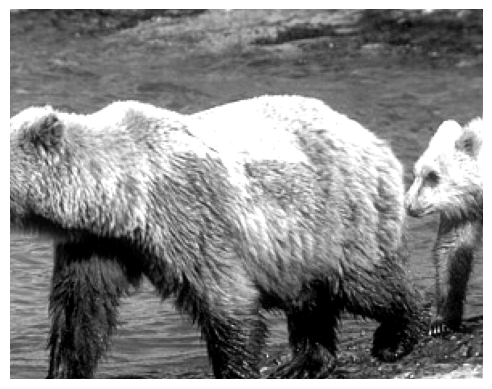

In [140]:
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(cache.get_natural_scene_template(0), cmap="gray")

In [126]:
metadata[metadata["stimulus_name"] == "natural_scenes"]["stimulus_condition_id"].unique()

array([4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918,
       4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929,
       4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940,
       4941, 4942, 4943, 4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951,
       4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962,
       4963, 4964, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973,
       4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984,
       4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995,
       4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006,
       5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014, 5015, 5016, 5017,
       5018, 5019, 5020, 5021, 5022, 5023, 5024, 5025, 5026])

In [ ]:
# session_data.presentationwise_spike_times()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
21.579087,0,915959976,0.000013
21.579387,0,915965400,0.000313
21.579587,0,915959890,0.000513
21.579787,0,915960262,0.000713
21.579961,0,915958751,0.000887
...,...,...,...
9143.415088,70387,915959974,0.249451
9143.415170,70387,915964551,0.249533
9143.415255,70387,915959708,0.249618


In [ ]:
# session_data.conditionwise_spike_statistics()

,,spike_count,stimulus_presentation_count,spike_mean,spike_std,spike_sem
unit_id,stimulus_condition_id,,,,,
915956282,0,6759,15,450.600000,617.813518,159.518764
915956304,0,10492,15,699.466667,1009.571187,260.670160
915956340,0,11240,15,749.333333,950.352316,245.379913
915956345,0,13776,15,918.400000,1291.497072,333.463110
915956349,0,22881,15,1525.400000,2196.381954,567.103382
...,...,...,...,...,...,...
915966905,5026,4,50,0.080000,0.444467,0.062857
915966931,5026,14,50,0.280000,0.858095,0.121353
915966963,5026,0,50,0.000000,0.000000,0.000000
